<a href="https://colab.research.google.com/github/gibsonx/CE888/blob/master/Lab_3/Exercis_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import itertools
from mlxtend.plotting import plot_confusion_matrix
from pandas.api.types import is_numeric_dtype,is_categorical_dtype
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score,cross_validate,ShuffleSplit,StratifiedKFold,train_test_split,KFold,GridSearchCV,cross_val_predict
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer,confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn import preprocessing


In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/albanda/ce888/master/lab3/bank-additional-full.csv", delimiter=";")

le = preprocessing.LabelEncoder()
df['y'] = le.fit_transform(df['y'])

print("Number of rows before dropping NaNs: %d" % len(df))
df = df.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))

df = df.drop(['duration'], axis=1)
print("Number of columns after dropping duration: %s" % df.shape[1] )

rows_contains_unknown = df[df.eq('unknown').any(axis=1)].index
df = df.drop(index=rows_contains_unknown)
print("Number of rows after dropping unknowns: %d" % len(df))

df = pd.get_dummies(df)
print("Number of rows after dropping unknowns: %d" % len(df))

count = 0
for column in df:
  if is_categorical_dtype(df[column]) == True:
    count += 1 
print("The number of numerical columns:", count)

X = df.iloc[:, df.columns != 'y']
y = df.iloc[:, df.columns == 'y']

Number of rows before dropping NaNs: 41188
Number of rows after dropping NaNs: 41188
Number of columns after dropping duration: 20
Number of rows after dropping unknowns: 30488
Number of rows after dropping unknowns: 30488
The number of numerical columns: 0


In [9]:
#Dummy_Classification
dummy_clf = DummyClassifier(strategy='stratified') #generates predictions by respecting the training set's class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
dumpy_scores = cross_val_score(dummy_clf, X=X_train,y=y_train.values.ravel(),cv=10,scoring='f1')
print("F1 Score for Dummy is: %.2f" % dumpy_scores.mean())


F1 Score for Dummy is: 0.13


In [13]:
#RandomForestClassifier with 10-fold verification
random_clf = RandomForestClassifier(n_estimators=200,max_depth=8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=50)
scores = cross_val_score(random_clf, X=X_train,y=y_train.values.ravel(),cv=10,scoring='f1')
print ("F1 Score for RandomForest is %0.2f:" % scores.mean())

F1 Score for RandomForest is 0.34:


In [5]:
#
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth' : [3,4,5],
}

clf = RandomForestClassifier()
hyper_parameter = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
hyper_parameter.fit(X_train,y_train.values.ravel())
print("hyper_parameters are:", hyper_parameter.best_params_)

hyper_parameters are: {'max_depth': 5, 'n_estimators': 200}


[0.19222103 0.1685131  0.11888533 0.09854836 0.07978765 0.07362835]
['nr.employed' 'euribor3m' 'pdays' 'poutcome_nonexistent' 'emp.var.rate'
 'cons.conf.idx']


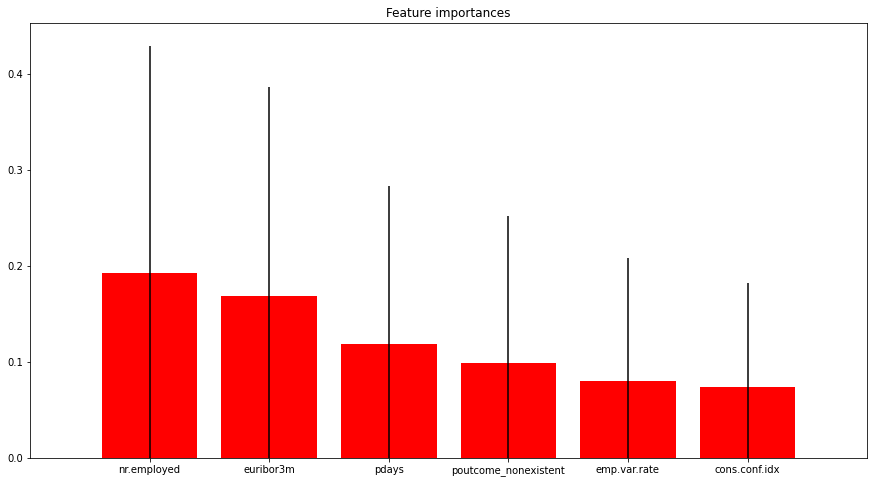

In [12]:
#importances analysis
random_clf = RandomForestClassifier(n_estimators=750,max_depth=6,random_state=60)
random_clf.fit(X_train, y_train.values.ravel())

importances = random_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in random_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print(importances[indices][:6])
print(np.array(df.columns)[indices][:6])

fig = plt.figure()
plt.title("Feature importances")
plt.bar(range(6), importances[indices][:6],
       color="r", yerr=std[indices][:6], align="center")
plt.xticks(range(6), np.array(df.columns)[indices][:6])
plt.xlim([-1, 6])
plt.ylim([0, None])

fig.set_size_inches(15, 8)
fig.set_size_inches(15, 8)

Normalized confusion matrix


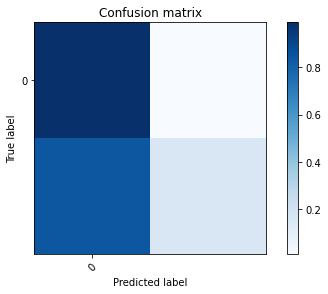

In [7]:
def plot_confusion_matrix(conf_mat, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        t = "(%.2f)" % (conf_mat[i, j])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
y_pred = random_clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test.values.ravel(),y_pred)

# plot_confusion_matrix(conf_mat=mat)

# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(len(set(y))), normalize=True,
                      title='Confusion matrix')